<h3>实现神经网络实例</h3>

1. 准备数据

In [7]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#导入预处理模块
import torchvision.transforms as transforms
# 导入数据加载器
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 3

In [8]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

In [9]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
example_data.shape

torch.Size([128, 1, 28, 28])

2. 可视化源数据

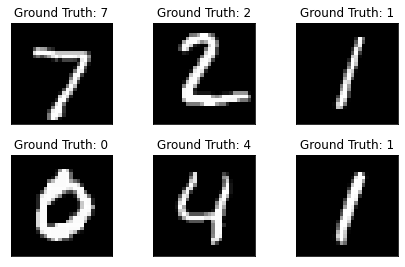

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


3. 构建模型

In [13]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

        # 除通过 Sequential 建立网络，还可以采用如下两种方法:

        # 1) Specify how data will pass through your model

        # self.fc1 = nn.Linear(in_dim, n_hidden_1)
        # self.BatchNorm1 = nn.BatchNorm1d(n_hidden_1)
        # self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        # self.BatchNorm2 = nn.BatchNorm1d(n_hidden_2)
        # self.fc3 = nn.Linear(n_hidden_2, out_dim)
        # 并在 forward() 中顺次连接

        # def forward(self, x):
        #   x = self.fc1(x)
        #   x = self.BatchNorm1(x)
        #   x = F.relu(x)
        #   x = fc2(x)
        #   x = BatchNorm2(x)
        #   x = F.relu(x)
        #   x = fc3(x)
        #   return x


        # 2) building weights and biases by nn.Parameter()

        # self.W1 = nn.Parameter(torch.randn(output_size, input_size), requires_grad=True)
        # self.b1 = nn.Parameter(torch.zeros(output_size, ), requires_grad=True)
        # self.W2 = ...
        # self.b2 = ...
        # ...

        # def forward(self, x):
        #     x = torch.matmul(x, self.W1.T) + self.b1.view(-1, 1)
        #     ...

In [14]:
lr = 0.01
momentum = 0.9

In [15]:
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs")
#    # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#    model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

4. 训练模型

In [16]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []


for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    
    
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向计算
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #net.eval() # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))


epoch: 0, Train Loss: 0.2190, Train Acc: 0.9381, Test Loss: 0.0971, Test Acc: 0.9708
epoch: 1, Train Loss: 0.0837, Train Acc: 0.9758, Test Loss: 0.0764, Test Acc: 0.9744
epoch: 2, Train Loss: 0.0577, Train Acc: 0.9817, Test Loss: 0.0661, Test Acc: 0.9793


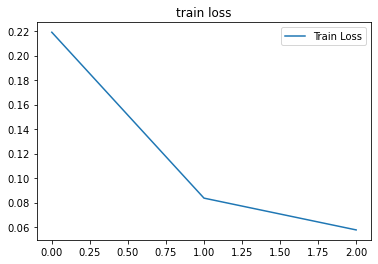

In [17]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')
